In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from math import log
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from tqdm import tqdm
from multiprocessing import Pool

In [2]:
df = pd.read_pickle('../data/watch_list_clean.pkl.xz')

## Normalize User Ratings to their own rating behavior

In [3]:
df.head()

,title,url,username,status,times_watched,user_rating,num_eps,is_ongoing,duration,studio,start_year,end_year,season,avg_rating,num_votes,synopsis,tags,content_warnings
0,Day Break Illusion: il sole penetra le illusioni,https://www.anime-planet.com/anime/day-break-i...,Ruth,Watched,1,3.0,13,False,NaN,AIC,2013.0,2013.0,Summer,3.158,1980,Akari has always known two things: she’s a ski...,"[Drama, Fantasy, Horror, Magical Girl, Contemp...",None
1,Dog Days,https://www.anime-planet.com/anime/dog-days,Ruth,Watched,1,3.5,13,False,NaN,Seven Arcs,2011.0,2011.0,Spring,3.524,9447,"In the magical land of Flonyard, animal-eared ...","[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
2,Dog Days',https://www.anime-planet.com/anime/dog-days-2,Ruth,Watched,1,3.0,13,False,NaN,Seven Arcs,2012.0,2012.0,Summer,3.651,5345,Three months have passed since Shinku returned...,"[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
3,Fantasista Doll,https://www.anime-planet.com/anime/fantasista-...,Ruth,Watched,1,2.5,12,False,NaN,Hoods Entertainment,2013.0,2013.0,Summer,2.918,1206,Uzume Uno was on her way to class one day when...,"[Magical Girl, Sci Fi, Seinen, Slice of Life, ...",None
4,Fate/Kaleid Liner Prisma Illya,https://www.anime-planet.com/anime/fate-kaleid...,Ruth,Watched,1,3.5,10,False,NaN,SILVER LINK.,2013.0,2013.0,Summer,3.513,5655,Illya loves magical girls; but more than anyth...,"[Action, Fantasy, Magical Girl, Shounen, Conte...",None


In [4]:
scaler = StandardScaler()
def user_rating_normalizer(group):
    scaled = scaler.fit_transform(group[['user_rating']])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=group.index)

In [5]:
def applyParallel(groups, func):
    num_workers = 16
    with Pool(num_workers) as p:
        return pd.concat(p.map(func, [group for name, group in groups])).sort_index()

In [6]:
df['adj_user_rating'] = applyParallel(df.groupby('username'), user_rating_normalizer)

In [7]:
df['adj_user_rating'].agg(['min', 'max'])

min   -27.748875
max    10.440307
Name: adj_user_rating, dtype: float32

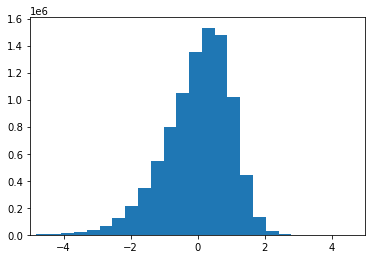

In [10]:
plt.hist(df['adj_user_rating'], bins=100)
plt.xlim(-5, 5)
plt.show()

<AxesSubplot:xlabel='adj_user_rating'>

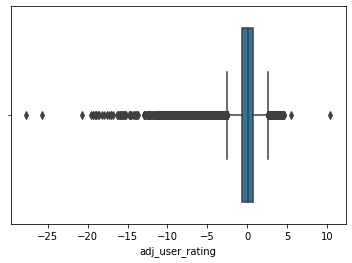

In [14]:
sns.boxplot(data=df, x='adj_user_rating')

## Weight Average Ratings based on Number of Votes

https://steamdb.info/blog/steamdb-rating/

In [73]:
df['adj_avg_rating'] = df['avg_rating'] - ((df['avg_rating'] - 2.75) * 2**(-np.log10(df['num_votes']) + 1))

## Normalize Average Ratings

In [74]:
scaler = StandardScaler()
def avg_rating_normalizer(data):
    scaled = scaler.fit_transform(data[['adj_avg_rating']])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=data.index)

In [75]:
df['adj_avg_rating'] = avg_rating_normalizer(df)

In [76]:
df['adj_avg_rating'].agg(['min', 'max'])

min   -5.611217
max    1.996216
Name: adj_avg_rating, dtype: float64

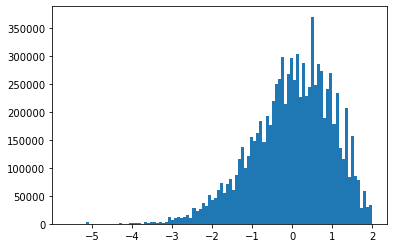

In [77]:
plt.hist(df['adj_avg_rating'], bins=100)
plt.show()

In [45]:
df.columns

Index(['title', 'url', 'username', 'status', 'times_watched', 'user_rating',
       'num_eps', 'is_ongoing', 'duration', 'studio', 'start_year', 'end_year',
       'season', 'avg_rating', 'num_votes', 'synopsis', 'tags',
       'content_warnings', 'adj_user_rating', 'adj_avg_rating'],
      dtype='object')

In [80]:
pivot = df.pivot(index='username', columns='title', values='adj_user_rating')

In [85]:
pivot.isnull().sum(axis=1)

username
000            4471
0001265        4427
00081          4454
00083115567    4425
000AMR000      4471
               ... 
zzmartineau    4472
zzombo         4365
zzz635         4461
zzzaw          4438
zzzleepyrin    4466
Length: 117162, dtype: int64

In [88]:
pivot

title,.hack//Legend Of The Twilight,.hack//Roots,.hack//SIGN,009-1,07-Ghost,100 Sleeping Princes & the Kingdom of Dreams,100% Pascal-sensei (2017),11eyes,12-Sai: Chiccha na Mune no Tokimeki,12-Sai: Chiccha na Mune no Tokimeki 2,...,gdgd Fairies,gdgd Fairies 2,gdgd men's party,number24,revisions,sola,www.Working!!,xxxHOLiC,xxxHOLiC Kei,ēlDLIVE
username,,,,,,,,,,,,,,,,,,,,,
000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00083115567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000AMR000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzmartineau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzombo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzz635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df.groupby('title')['adj_avg_rating'].first()

title
.hack//Legend Of The Twilight   -1.206446
.hack//Roots                    -0.868088
.hack//SIGN                     -0.861448
009-1                           -2.314338
07-Ghost                        -0.485324
                                   ...   
sola                            -0.649361
www.Working!!                   -0.452581
xxxHOLiC                         0.290803
xxxHOLiC Kei                     0.723494
ēlDLIVE                         -2.382255
Name: adj_avg_rating, Length: 4473, dtype: float64